# SDTSIA210 Data Challenge - Marine Mercier & Paul Fayard

In [3]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from time import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier,StackingClassifier

from scipy.stats import uniform, randint
import scipy.stats as st

import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier 


# Introduction 

Challenge : Fusion of algorithms for face recognition

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images.

Comparing of two images is done in two steps. 1st, a vector of features is computed for each image. 2nd, a simple function produces a vector of scores for a pair of images. The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.

Note on our work: 

We both worked locally on our devices. 
As it was difficult to work on a single notebook, we decided to share the work. Everyone worked on different methods, and we regularly shared our observations and results in order to move in the same direction. 
At the end, we merged the two notebooks and obtained this one.

## Loading of the data

In [3]:
X = np.loadtxt('xtrain_challenge.csv', delimiter=',', skiprows = 1)
Y = np.loadtxt('ytrain_challenge.csv', delimiter=',', skiprows = 1)

In [4]:
#Data that we are going to predict at the end
X_exam = np.loadtxt('xtest_challenge.csv', delimiter=',', skiprows = 1)

In [5]:
np.save("X_exam.npy",X_exam)

We shuffle the data to make sure that our training/test sets are representative of the overall distribution of the data, and therefore, to make sure that we are not going to overfit on a small proportion of our data.

In [7]:
N=X.shape[0]
ordre=np.arange(0,N)
np.random.shuffle(ordre)

# Use as new variables
X=X[ordre[:]]
Y=Y[ordre[:]]

## Observation of the data

The first step of our work was to try to understand the dataset we had to work on. 
We had a total of 1,068,504 training observations from which we had to train a model to predict 3,318,296 test observations. 
Each of the training observations, corresponding to two images, has 37 features and one label: 0 or 1. The label is 1 if the two images correspond to the same person, 0 otherwise. We are thus in the case of supervised learning and more precisely of binary classification.  

In [26]:
print("The shape of the labels is ",Y.shape,".")
print("The training set consists of labels: ",np.unique(Y))
print("The shape of the observations is ",X.shape,".")
print("We work with ",X.shape[0]," data and each one has ",X.shape[1]," features.")
print("We are going to predict ",X_exam.shape[0]," new observations.")

The shape of the labels is  (1068504,) .
The training set consists of labels:  [0. 1.]
The shape of the observations is  (1068504, 37) .
We work with  1068504  data and each one has  37  features.
We are going to predict  3318296  new observations.


In [7]:
print(str(Y.mean()*100),"% of the observations have the label 1.")
print(str((1-Y.mean())*100),"% of the observations have the label 0.")

3.7054610932668477 % of the observations have the label 1.
96.29453890673315 % of the observations have the label 0.


We soon noticed that the classes were very unbalanced. 
Indeed, among the training observations, more than 96% of the data had the label 0.
We thought that we would have to adapt our algorithms to this imbalance because, it could be that our classifier only learns the majority class, and returns the label 0 for each data.

First of all, we thought we would do ***data augmentation***, i.e. create new training observations from our training observations with label 0. You'll see that Marine has worked on it in her notebook. 

On the other hand, we saw that most classifiers had a ***"class_weight" argument*** which allowed us to give more or less importance to the different classes in the loss function. Thus, we played with this parameter, penalizing more an error on a label 1 training observation than an error on a label 0 training observation. 
All we wanted to ***avoid was that our model doesn't systematically return 0***, and most classifiers didn't need this to learn something from our data.

#### Scale of the data

To get the best accuracy for our predictions, we have to work with good data. 
Our first reflex was to use a linear transformation to standardize our data (mean=0 and std=1). We applied this to the training and the test set. This avoids that some features are more important than others for no reason. We will see that it has been useful for some of our models, such as SVM or MLPClassifier. 

In [8]:
"""
# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scale=scaler.transform(X)
X_exam_scale=scaler.transform(X_exam)

"""

'\n# Scale data (each feature will have average equal to 0 and unit variance)\n\nscaler = StandardScaler()\nscaler.fit(X)\nX_scale=scaler.transform(X)\nX_exam_scale=scaler.transform(X_exam)\n\n'

#### Division of the data in training set / test set

Once we had our standardized data, the big question was: how are we going to divide our data?
Because we have over 1 million observations we knew that if we worked with all of them, the model training would be very long (espacially the choice of the hyper-parameters). 

So we made the choice to shuffle our data and to work with 1/8 of the data at the beginning, at the risk of losing a little bit of accuracy. Once the model has been chosen, we will work with all the data. 

In [9]:
N=len(X)

X_small=X[:N//8]
Y_small=Y[:N//8]

NOTE : In this notebook, we work with an eighth of the data. 

In other notebooks, we tested the different classifiers with all the data. For some models this was very time consuming, so we can't start all over again in this notebook. That's why here we work with one out of eight data, which was not the case at the time of submission.

We then divided our data into two sets, the training set, and the test set which will allow us to test our models, and above all to check that we haven't overfitted them. The latter is made up of 33% of the data retained. 

In [8]:
small=0

In [9]:
if small==1:
    
    print("To work with 1/8 of the data (to make faster training/tests).")
    X_train, X_test ,y_train, y_test = train_test_split(X_small,Y_small, test_size=0.20, random_state=42)
else:
    print("To work with all the data.") 
    X_train, X_test ,y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

To work with all the data.


## Our strategy 

After that, our approach was to test different models as we went along.
We used simple model at the beginning, but we quickly realized that, due to the number of data and the size of the features, we needed a very complex model to learn such important data.

We then compared the scores of our different classifiers, scores on the test set, to finally retain the best one.

## Useful functions

In [3]:
#To print the confusion matrix

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

classes_name=["label 0","label 1"]

In [4]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1,figsize=(20,15))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores, random_state", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [20]:
def submit(y_exam=None,model=None,X_exam=None):
    #save our results in a csv file
    if model !=None:
        y_exam=model.predict(X_exam)
    np.savetxt('ytest_challenge_student.csv', y_exam, fmt = '%1.0d', delimiter=',')
    

## 1- First try with KNN

---

Knn is a very ***simple*** model. We use it to make a first test and see if we can draw some conclusions.

We work will 1/8 of the data because the ***prediction step is very long*** with this method, as we must evaluate such a great number of distances.

---

In [19]:
#We use the default parameters : n_neighbors=5

KNN = KNeighborsClassifier()
KNN.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [20]:
KNN.score(X_train,y_train)

0.9979316799251287

In [22]:
s2=KNN.score(X_test,y_test)

In [24]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.72298131995657 %.


Normalized confusion matrix
[[9.99494891e-01 5.05109376e-04]
 [6.25000000e-02 9.37500000e-01]]


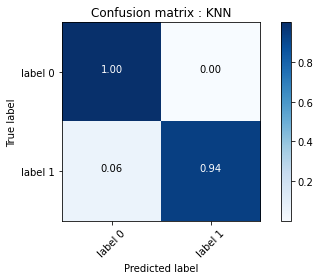

In [25]:
#Confusion matrix to analyse the faults 
y_pred=KNN.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.title("Confusion matrix : KNN")
plt.show()

Bilan : 

Dataset| Scores 
- |-: 
training set  | 99,79%
test set | 99,72% 

--- 

We see that even we a very simple model, we reach excellent scores. It predicts perfectly the class 0. There are a ***few mistakes over the label 1***, that is the minority class.

Without looking as the best parameter for n_neihbors, we are going to test directly a more complex classifier.
In fact, the KNN method is not often used because of its ***slowness***, especially for predicting large datasets like ours, and because of its inability to manage a lot of features (here 37).

The method that we are going to study next doesn't have these drawbacks.

---

## 2- Linear models : SVM

--- 

We are going to deal with a linear model, that realize predictions with a linear functions of the input features.
We know that linear models are good for very large datasets, with large dimensions, that is our case.

We have chosen SVM, one of these linear models, the one we've seen the most detail of in class.

* For this model small=0: we work with all the data because it is faster than KNN
* Here, the standardization of our data is very important. 

---

In [17]:
#Standardization of the data

mean_on_train=X_train.mean(axis=0)
std_on_train=X_train.std(axis=0)

X_train_scaled=(X_train-mean_on_train)/std_on_train
X_test_scaled=(X_test-mean_on_train)/std_on_train
X_exam_scaled=(X_exam-mean_on_train)/std_on_train

In [35]:
#Default parameters 

svm1=LinearSVC()
svm1.fit(X_train_scaled,y_train)

/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [36]:
svm1.score(X_train_scaled,y_train)

0.9981030790742244

In [37]:
s2=svm1.score(X_test_scaled,y_test)

In [38]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.80544912608089 %.


Normalized confusion matrix
[[9.99301814e-01 6.98186189e-04]
 [3.41289146e-02 9.65871085e-01]]


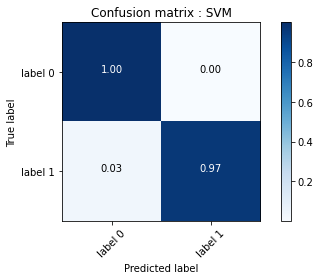

In [39]:
#Confusion matrix to analyse the faults 
y_pred=svm1.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.title("Confusion matrix : SVM")
plt.show()

Bilan : 

Dataset| Scores 
- |-: 
training set  | 99,81%
test set | 99,80% 

--- 

With default parameters, we were already getting very interesting scores.It's again a perfect for label 0, and we have improved our prediction of label 1.

We quickly understood that a sufficiently complex model was able to obtain scores higher than 99% on the test set, we would have to go for scores higher than 99.8% to stay in the competition. 

---

### Searching the best hyper-parameters

---

For the first time, we're going to go deeper into this model,by looking for the best hyper-parameters.

We are going to play on two parameters : 
 * C : Regularization parameter. The strength of the regularization is inversely proportional to C.
 * class-weight : Set the parameter C of class i to class_weight[i]*C for SVC. We see if we change stg by giving more weight to the minority class.
 
--- 

In [95]:
parameters={'C':[0.01,0.1,1],
           'class_weight': [{0:1,1:1},{0:1,1:5},{0:1,1:15}]}

Then, we search the best combination of these two parameters by doing a GridSearch with cross-validation :

In [96]:
grid = GridSearchCV(LinearSVC(), parameters)
grid.fit(X_train_scaled,y_train)

/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/paul/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 5},
                                          {0: 1, 1: 15}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best parameters : 

In [97]:
grid.best_params_

{'C': 0.1, 'class_weight': {0: 1, 1: 1}}

Corresponding score : 

In [98]:
grid.best_score_

0.9977985661648525

--- 

It's weird but our best score is inferior to the score we get without doing the gridsearch. With this model, tuning the parameters doesn't change a lot our scores. Also, the best parameter 'class_weights" is {0:1,1:1}, ie equal weights for each class. It means that we don't really need to adapt our algorithm to the fact that the class are unbalanced. Both class must be sufficiently weel separated. 

The big advantage of linear models is that they are very fast in terms of prediction and training. They are also able to adapt to large datasets like ours. 

So we managed to improve our score over KNN. 
However, we are still far from the 0.9985 we are now aiming for. 
In order not to waste time, and because we are eager to train more complex models, we will move directly to the next step.

Idea we could have done to improve this step: 
- do some regularization with Ridge and LASSO (but it seems useless because we don't really overfit)
- try SVM with kernels

---

In [41]:
#TO SUBMIT : 
submit(model=svm1,X_exam=X_exam_scaled)

## 3- Neural Networks

--- 

We need a more complex classifier so that our score goes up to 0,9985.
For our neural network, we chose to use the sklearn.neural_network library and the MLPClassifier model, that is very quick.

Let's do a first try without taking care of the parameters : 

(Again we work with the scaled version of our data)

---

In [43]:
mlp=MLPClassifier(hidden_layer_sizes=(15,),verbose=1,max_iter=500,random_state=0)

In [44]:
mlp.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03063585
Iteration 2, loss = 0.00673447
Iteration 3, loss = 0.00594956
Iteration 4, loss = 0.00560891
Iteration 5, loss = 0.00536448
Iteration 6, loss = 0.00522307
Iteration 7, loss = 0.00510961
Iteration 8, loss = 0.00505204
Iteration 9, loss = 0.00499033
Iteration 10, loss = 0.00494338
Iteration 11, loss = 0.00488052
Iteration 12, loss = 0.00484259
Iteration 13, loss = 0.00480436
Iteration 14, loss = 0.00478234
Iteration 15, loss = 0.00473177
Iteration 16, loss = 0.00469255
Iteration 17, loss = 0.00464473
Iteration 18, loss = 0.00461066
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [45]:
mlp.score(X_train_scaled,y_train)

0.9984550850192137

In [46]:
s2=mlp.score(X_test_scaled,y_test)

In [47]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.82359964493047 %.


Normalized confusion matrix
[[9.99540434e-01 4.59565593e-04]
 [3.54211006e-02 9.64578899e-01]]


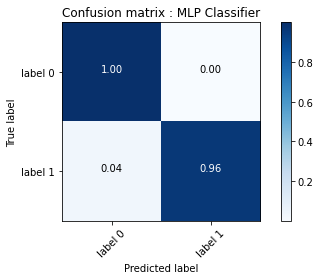

In [49]:
#Confusion matrix to analyse the faults 
y_pred=mlp.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.title("Confusion matrix : MLP Classifier")
plt.show()

Bilan : 

Dataset| Scores 
- |-: 
training set  | 99,84%
test set | 99,82% 

Without doing any gridsearch, just by testing a MLP with one layer and 15 neurons, we reach very good scores.


So we thought it was a model to dig. 
The big advantage of this model compared to the models we'll see later is that the training was very fast. 

So we have tested various parameters. 
We played with: 
- hidden_layer_sizes : the number of layer and neurons per layer
- the learning rate : constant or invscaling (gradually decreases the learning rate at each epoch)
- tol: stopping criterion, if the score has not increased by at least tol, the training stops (we change it by hand, we expect to improve the training with a very small tol)

The problem is that the parameter tuning didn't change much. 
The few times we got a score on the test set, above 99.86%, we got "only" 99.80 when submitting our model. 
Another defect is that the tol parameter can't be as small as we want. The training lasts a maximum of 70 epochs. We can't get an accuracy as small as we want to the thousandth, while every decimal place is important in this project. 

Paradoxically, the best score we submitted comes from a model whose parameters were obtained "by hand", i.e. without gridsearch.

In [17]:
res=[]
for i in range(10,200,20):
    for j in range(10,100,10):
        res.append((i,j))
    res.append((i,))

param = {
    'hidden_layer_sizes': res,
    'learning_rate':['constant','invscaling'],
    }

model = MLPClassifier(tol=0.00001,max_iter=300)

grid = RandomizedSearchCV(model, param, n_iter=50, cv=5, n_jobs=-1,verbose=1)
grid.fit(X_train_scaled, y_train)

print('The best hidden_layer_sizes is ', grid.best_params_.get('hidden_layer_sizes'),' with an average validation score equal to ', grid.best_score_)
print('It s better to work with leatning rate =', grid.best_params_.get('learning_rate'))

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test_scaled, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 40.9min finished


The best hidden_layer_sizes is  (130, 50)  with an average validation score equal to  0.9980443993179756
It s better to work with leatning rate = invscaling
The test score is 0.9977765677466195


In [18]:
mlp=MLPClassifier(hidden_layer_sizes=(130,5),learning_rate='invscaling',verbose=1,max_iter=500,random_state=0)

In [20]:
mlp.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.04328032
Iteration 2, loss = 0.00828405
Iteration 3, loss = 0.00686279
Iteration 4, loss = 0.00601021
Iteration 5, loss = 0.00533653
Iteration 6, loss = 0.00511262
Iteration 7, loss = 0.00446764
Iteration 8, loss = 0.00445541
Iteration 9, loss = 0.00431391
Iteration 10, loss = 0.00373403
Iteration 11, loss = 0.00337345
Iteration 12, loss = 0.00317996
Iteration 13, loss = 0.00285204
Iteration 14, loss = 0.00268906
Iteration 15, loss = 0.00245521
Iteration 16, loss = 0.00252386
Iteration 17, loss = 0.00236168
Iteration 18, loss = 0.00235667
Iteration 19, loss = 0.00172009
Iteration 20, loss = 0.00166245
Iteration 21, loss = 0.00134417
Iteration 22, loss = 0.00124160
Iteration 23, loss = 0.00113403
Iteration 24, loss = 0.00100340
Iteration 25, loss = 0.00096585
Iteration 26, loss = 0.00090362
Iteration 27, loss = 0.00077585
Iteration 28, loss = 0.00059776
Iteration 29, loss = 0.00145707
Iteration 30, loss = 0.00182690
Iteration 31, loss = 0.00089151
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(130, 5), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [22]:
mlp.score(X_train_scaled,y_train)

0.9996535809670678

In [23]:
mlp.score(X_test_scaled,y_test)

0.9978219439150559

In [24]:
y_pred=mlp.predict(X_test_scaled)

Normalized confusion matrix
[[9.99175073e-01 8.24926935e-04]
 [3.70145631e-02 9.62985437e-01]]


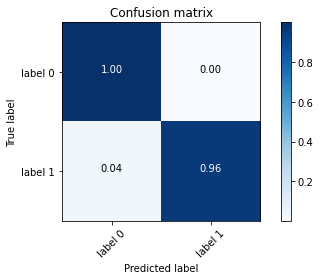

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

---

The problem is that the parameter tuning didn't change much. 

The few times we got a score on the test set above 99.86%, we got "only" 99.80 when submitting our model. 
Another defect is that the tol parameter can't be as small as we want. The training lasts a maximum of 70 epochs. We can't get an accuracy as small as we want to the thousandth, while every decimal place is important in this project. 

Paradoxically, the best score we submitted comes from a model whose parameters were obtained "by hand", i.e. without gridsearch.

In an attempt to further improve our score, we decided to learn more about the models that frequently win machine learning competitions. 
That's how we found a model that frequently seemed to be above the others, called xgboost. 

---

In [50]:
#TO SUBMIT : 
submit(model=mlp,X_exam=X_exam_scaled)

## 4- XGBOOST

---

***What is XGBoost?***

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.

It’s in fact an optimized gradient boosting algorithm through parallel processing, tree-pruning, handling missing values and regularization to avoid overfitting. XGBoost algorithm was developed as a research project at the University of Washington by Tianqi Chen and Carlos Guestrin. 

---

First we gonna test it with default parameters. We don't need to have our data scaled here, so we use X_train and not X_train scaled. 

In [51]:
t0 = time()
boost = XGBClassifier()
boost.fit(X_train,y_train)
print("Classification done in "+str(time() - t0)+"s")

Classification done in 69.51561117172241s


In [52]:
boost.score(X_train,y_train)

0.9999804441141673

In [55]:
s2=boost.score(X_test,y_test)

In [56]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.8896788776173 %.


This score is the best we've had since the beginning so we'll try to submit it right away and see what it says about the data to predict.

In [54]:
#TO SUBMIT
submit(model=boost,X_exam=X_exam)

SCORE OBTAINED : ***0.998423889852***. 

This is good but we can do better. 

Normalized confusion matrix
[[9.99578732e-01 4.21268460e-04]
 [1.86986926e-02 9.81301307e-01]]


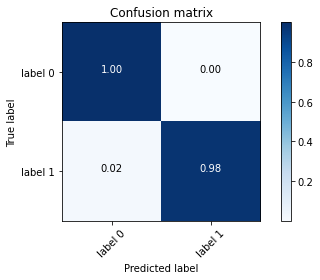

In [57]:
#Confusion matrix to analyse the faults 
y_pred=boost.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

As expected, this model, winner in many Kaggle competitions, allowed us to get good scores directly. It's the first time we achieve such score on the test sets, and especially the first time our prediction on label 1 reach 0.98.


However, xgboost has two major drawbacks: 

- its training time: on our computers, a training on all training observations could take up to 10 minutes. 

- its number of hyper-parameters to be adjusted : 
By reading on the internet tips for tuning the hyper-parameters of the xgboost, we have seen that the number of parameters to play with is 6. 

source : https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

Here is the list of parameter that we are going to examine : 

* max_depth : Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

* gamma : Minimum loss reduction required to make a further partition on a leaf node of the tree. 

* n_estimators : very important. The number of boosting stages to perform.

* learning_rate : learning rate shrinks the contribution of each tree by learning_rate.

* subsample : Subsample ratio of the training instance.

* colsample_bytree : subsample ratio of columns when constructing each tree.

In [10]:
params_fixed={'objective':'binary:logistic','silent':0}

In [11]:
params_dist_grid={
    'max_depth':range(3,10,2),
    'gamma':[0,0.5,1],
    'n_estimators':randint(30,500),
    'learning_rate':uniform(),
    'subsample':uniform(),
    'colsample_bytree':uniform()
}

By testing 6 values for each of the parameters, we obtain 6⁶=46,656 possibilities. If we count 5 minutes per iteration, we get 233,280 minutes, 3888 hours, 162 days. And still, we did not take into account that the cross validation practiced in the gridsearch took even more time than a simple training. 

In other words, it was totally impossible to test all possible parameters. 
That's why we chose to use a RandomizedGridSearchCV. With this type of approach, we choose the number of possibilities we will test. 
These will be randomly selected among the possibilities that we have entered as input. 
So we are not sure to get a maximum overall score, but the best combination of parameters will probably give a very good score. 
In terms of the number of possibilities to test, we've chosen to test 50, which is enough to keep the training running for a long afternoon.

Here is the correspondig code. It take one night to make the 50 iterations.

In [23]:
rd_grid=RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed,seed=seed),param_distributions=params_dist_grid,
n_iter=50,
cv=3,
scoring='accuracy',
random_state=seed,
verbose=10
)

In [24]:
rd_grid.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   4.3s
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.996, total=   4.2s
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   4.2s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  39.4s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   52.0s remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  39.7s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  40.0s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.2min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.998, total=  16.0s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.999, total=  16.0s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.7min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.999, total=  20.3s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.1min remaining:    0.0s


[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  31.6s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 
[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  28.2s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 
[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  29.0s
[CV] colsample_bytree=0.4636309538821305, gamma=0, learning_rate=0.7652628330253548, max_depth=3, n_estimators=217, subsample=0.005635524386628399 
[CV]  colsample_bytree=0.46363095

[CV]  colsample_bytree=0.4288656296016934, gamma=0.5, learning_rate=0.6730164898324128, max_depth=5, n_estimators=410, subsample=0.7248087016755762, score=0.999, total= 1.3min
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579, score=0.997, total=  23.7s
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579, score=0.997, total=  23.8s
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  co

[CV]  colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981, score=0.999, total=  42.5s
[CV] colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981 
[CV]  colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981, score=0.999, total=  43.5s
[CV] colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438 
[CV]  colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438, score=0.997, total=   6.4s
[CV] colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.998, total=   6.6s
[CV] colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703 
[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.998, total=   6.7s
[CV] colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703 
[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.999, total=   6.6s
[CV] colsample_bytree=0.1233781606164811, gamma=0.5, learning_rate=0.09772802614862519, max_depth=3, n_estimators=295, subsample=0.32162421002224917 
[CV]  colsample_bytree=0.1233781606164811

[CV]  colsample_bytree=0.45294600144107167, gamma=1, learning_rate=0.08303834961595746, max_depth=7, n_estimators=187, subsample=0.6069127728741993, score=0.999, total=  51.9s
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962, score=0.998, total=66.2min
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962, score=0.999, total= 1.1min
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008

[CV]  colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632, score=0.998, total=  55.1s
[CV] colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632 
[CV]  colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632, score=0.998, total=  55.6s
[CV] colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713 
[CV]  colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713, score=0.999, total= 1.0min
[CV] colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713 
[CV]  colsample_bytree=0.675408669444132

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 199.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f049e0eccf8>,
                                        'max_depth'

In [25]:
rd_grid.best_score_

0.9988126784811241

The best parameters found are : 

In [26]:
rd_grid.best_params_

{'colsample_bytree': 0.5213285655977811,
 'gamma': 1,
 'learning_rate': 0.12245745743134928,
 'max_depth': 5,
 'n_estimators': 448,
 'subsample': 0.48831719352338554}

Then, we test this model, considered to be the best one : 

In [59]:
clf=XGBClassifier(colsample_bytree= 0.5213285655977811,
 gamma= 1,
 learning_rate= 0.12245745743134928,
 max_depth= 5,
 n_estimators= 448,
 subsample= 0.48831719352338554,objective='binary:logistic')

In [60]:
clf.fit(X,Y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5213285655977811, gamma=1,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              learning_rate=0.12245745743134928, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=448, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.48831719352338554,
              tree_method=None, validate_parameters=False, verbosity=None)

In [61]:
clf.score(X_test,y_test)

0.9999319357473455

In [62]:
#TO SUBMIT : 
submit(model=clf,X_exam=X_exam)

We wanted to improve again this score, so we try the RandomizedSearchCV another night with twice more iterations.

In [14]:
rd_grid=RandomizedSearchCV(
    estimator=XGBClassifier(**params_fixed,seed=seed),param_distributions=params_dist_grid,
n_iter=100,
cv=3,
scoring='accuracy',
random_state=seed,
verbose=10
)

In [15]:
rd_grid.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   3.3s
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   3.3s
[CV] colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s


[CV]  colsample_bytree=0.06503439684192913, gamma=0, learning_rate=0.24756150723102166, max_depth=7, n_estimators=34, subsample=0.11848249237448605, score=0.997, total=   3.3s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  36.6s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   46.5s remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  38.5s
[CV] colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min remaining:    0.0s


[CV]  colsample_bytree=0.13214054942810016, gamma=0, learning_rate=0.4325346125891868, max_depth=3, n_estimators=457, subsample=0.8942723823370169, score=0.999, total=  38.5s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.1min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.998, total=  16.4s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.3min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.999, total=  15.8s
[CV] colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.6min remaining:    0.0s


[CV]  colsample_bytree=0.1523931947190449, gamma=1, learning_rate=0.23096728629607655, max_depth=7, n_estimators=91, subsample=0.7099300190073073, score=0.999, total=  15.9s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.9min remaining:    0.0s


[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  27.5s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 
[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  27.8s
[CV] colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573 
[CV]  colsample_bytree=0.22187963515640408, gamma=1, learning_rate=0.3807697564898246, max_depth=7, n_estimators=142, subsample=0.8058014316376573, score=0.999, total=  28.5s
[CV] colsample_bytree=0.4636309538821305, gamma=0, learning_rate=0.7652628330253548, max_depth=3, n_estimators=217, subsample=0.005635524386628399 
[CV]  colsample_bytree=0.46363095

[CV]  colsample_bytree=0.4288656296016934, gamma=0.5, learning_rate=0.6730164898324128, max_depth=5, n_estimators=410, subsample=0.7248087016755762, score=0.999, total= 1.3min
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579, score=0.997, total=  24.7s
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579, score=0.997, total=  24.9s
[CV] colsample_bytree=0.0017306007327145823, gamma=0.5, learning_rate=0.05315918465055469, max_depth=9, n_estimators=205, subsample=0.8061810315662579 
[CV]  co

[CV]  colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981, score=0.999, total=  43.7s
[CV] colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981 
[CV]  colsample_bytree=0.4697145869577216, gamma=0.5, learning_rate=0.39720907308977726, max_depth=3, n_estimators=312, subsample=0.9607885510753981, score=0.999, total=  43.5s
[CV] colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438 
[CV]  colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438, score=0.997, total=   6.5s
[CV] colsample_bytree=0.1807105983444972, gamma=0.5, learning_rate=0.7116905005504024, max_depth=7, n_estimators=43, subsample=0.12476164013176438 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.998, total=   7.1s
[CV] colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703 
[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.998, total=   7.1s
[CV] colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703 
[CV]  colsample_bytree=0.7494207571997938, gamma=1, learning_rate=0.5669082329780527, max_depth=3, n_estimators=35, subsample=0.8936616121288703, score=0.999, total=   7.1s
[CV] colsample_bytree=0.1233781606164811, gamma=0.5, learning_rate=0.09772802614862519, max_depth=3, n_estimators=295, subsample=0.32162421002224917 
[CV]  colsample_bytree=0.1233781606164811

[CV]  colsample_bytree=0.45294600144107167, gamma=1, learning_rate=0.08303834961595746, max_depth=7, n_estimators=187, subsample=0.6069127728741993, score=0.999, total=  53.0s
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962, score=0.999, total= 1.1min
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962, score=0.999, total= 1.1min
[CV] colsample_bytree=0.7327546305008223, gamma=0.5, learning_rate=0.692803142146249, max_depth=7, n_estimators=180, subsample=0.705851693379962 
[CV]  colsample_bytree=0.7327546305008

[CV]  colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632, score=0.998, total=  53.9s
[CV] colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632 
[CV]  colsample_bytree=0.919421811544759, gamma=1, learning_rate=0.9622594737743404, max_depth=5, n_estimators=158, subsample=0.6372091818441632, score=0.998, total=  54.4s
[CV] colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713 
[CV]  colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713, score=0.999, total= 1.0min
[CV] colsample_bytree=0.6754086694441321, gamma=0, learning_rate=0.22800333163252395, max_depth=9, n_estimators=165, subsample=0.4357666773827713 
[CV]  colsample_bytree=0.675408669444132

[CV]  colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251, score=0.996, total=   7.0s
[CV] colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251 
[CV]  colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251, score=0.995, total=   6.9s
[CV] colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251 
[CV]  colsample_bytree=0.09712926011751544, gamma=1, learning_rate=0.026293094084396507, max_depth=7, n_estimators=59, subsample=0.08470617912256251, score=0.995, total=   6.8s
[CV] colsample_bytree=0.4660191122328683, gamma=0.5, learning_rate=0.2721599325974995, max_depth=5, n_estimators=184, subsample=0.7718717535091743 
[CV]  colsample_bytree=

[CV]  colsample_bytree=0.8997330149392108, gamma=0.5, learning_rate=0.3835247744746083, max_depth=5, n_estimators=356, subsample=0.7052102240395378, score=0.999, total= 2.0min
[CV] colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892 
[CV]  colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892, score=0.997, total=  26.1s
[CV] colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892 
[CV]  colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892, score=0.997, total=  27.4s
[CV] colsample_bytree=0.8274594348493765, gamma=0, learning_rate=0.9807421345062718, max_depth=7, n_estimators=357, subsample=0.007095876549151892 
[CV]  colsample_bytree=0.827

[CV]  colsample_bytree=0.33627139494857383, gamma=0.5, learning_rate=0.24389578673746937, max_depth=3, n_estimators=180, subsample=0.5248144499730755, score=0.999, total=  23.5s
[CV] colsample_bytree=0.33627139494857383, gamma=0.5, learning_rate=0.24389578673746937, max_depth=3, n_estimators=180, subsample=0.5248144499730755 
[CV]  colsample_bytree=0.33627139494857383, gamma=0.5, learning_rate=0.24389578673746937, max_depth=3, n_estimators=180, subsample=0.5248144499730755, score=0.999, total=  23.5s
[CV] colsample_bytree=0.8258550253895973, gamma=0.5, learning_rate=0.2522783789438505, max_depth=9, n_estimators=70, subsample=0.9167099703054473 
[CV]  colsample_bytree=0.8258550253895973, gamma=0.5, learning_rate=0.2522783789438505, max_depth=9, n_estimators=70, subsample=0.9167099703054473, score=0.999, total=  37.7s
[CV] colsample_bytree=0.8258550253895973, gamma=0.5, learning_rate=0.2522783789438505, max_depth=9, n_estimators=70, subsample=0.9167099703054473 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684, score=0.998, total= 1.0min
[CV] colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684 
[CV]  colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684, score=0.999, total= 1.0min
[CV] colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684 
[CV]  colsample_bytree=0.4715416412473765, gamma=1, learning_rate=0.2662630192036526, max_depth=5, n_estimators=369, subsample=0.21027234582906684, score=0.999, total= 1.0min
[CV] colsample_bytree=0.5139404691578969, gamma=0.5, learning_rate=0.2999675136645916, max_depth=9, n_estimators=278, subsample=0.8277418366554766 
[CV]  colsample_bytree=0.51394046

[CV]  colsample_bytree=0.9564638424139361, gamma=0, learning_rate=0.28181496645949267, max_depth=7, n_estimators=425, subsample=0.3361040265850367, score=0.999, total= 2.4min
[CV] colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654 
[CV]  colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654, score=0.997, total=  32.4s
[CV] colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654 
[CV]  colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654, score=0.997, total=  32.0s
[CV] colsample_bytree=0.3625473603983238, gamma=0.5, learning_rate=0.886975127977201, max_depth=3, n_estimators=420, subsample=0.04016312842699654 
[CV]  colsample_bytree=0.3625

[CV]  colsample_bytree=0.5060506125373518, gamma=0.5, learning_rate=0.64099934659491, max_depth=9, n_estimators=166, subsample=0.3027654384906646, score=0.998, total=  42.4s
[CV] colsample_bytree=0.5060506125373518, gamma=0.5, learning_rate=0.64099934659491, max_depth=9, n_estimators=166, subsample=0.3027654384906646 
[CV]  colsample_bytree=0.5060506125373518, gamma=0.5, learning_rate=0.64099934659491, max_depth=9, n_estimators=166, subsample=0.3027654384906646, score=0.998, total=  43.7s
[CV] colsample_bytree=0.9983862721241882, gamma=0.5, learning_rate=0.2159654911802783, max_depth=5, n_estimators=232, subsample=0.9385444349357669 
[CV]  colsample_bytree=0.9983862721241882, gamma=0.5, learning_rate=0.2159654911802783, max_depth=5, n_estimators=232, subsample=0.9385444349357669, score=0.999, total= 1.4min
[CV] colsample_bytree=0.9983862721241882, gamma=0.5, learning_rate=0.2159654911802783, max_depth=5, n_estimators=232, subsample=0.9385444349357669 
[CV]  colsample_bytree=0.998386272

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 257.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc68131c710>,
                                        'max_depth'

Here are our new best parameters : 

In [19]:
rd_grid.best_params_

{'colsample_bytree': 0.9983862721241882,
 'gamma': 0.5,
 'learning_rate': 0.2159654911802783,
 'max_depth': 5,
 'n_estimators': 232,
 'subsample': 0.9385444349357669}

Let's compare them to the parameters found the night before : 

{'colsample_bytree': 0.5213285655977811,
 'gamma': 1,
 'learning_rate': 0.12245745743134928,
 'max_depth': 5,
 'n_estimators': 448,
 'subsample': 0.48831719352338554}
 
The max_depth of the trees is the same, 5.

This model considers less estimators (232 vs 448) but for each iterator, the subsample ratio of the training instance picked is largely superior as the subsample ratio of columns when constructing each tree..

We test this new model :

In [68]:
clf=XGBClassifier(colsample_bytree= 0.9983862721241882,
 gamma= 0.5,
 learning_rate= 0.2159654911802783,
 max_depth= 5,
 n_estimators= 232,
 subsample= 0.9385444349357669,objective='binary:logistic')

In [69]:
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9983862721241882,
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.2159654911802783,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=232, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9385444349357669, tree_method=None,
              validate_parameters=False, verbosity=None)

In [70]:
clf.score(X_test,y_test)

0.9983664579362919

In [ ]:
#TO SUBMIT : 
submit(model=clf,X_exam=X_exam)

This is currently our best score : ***0.998519119452***.

## 5- Going further 

### Ensemble methods 

---

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Marine is going to deal with ensemble methods as Adaboost or Random forests and I'm going to try Voting Classifier and Stacking.

---

#### Voting Classifier

---

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

source : https://scikit-learn.org/stable/modules/ensemble.html

First I'm going to try with 3 models :

I needed another very good classifier to be able to implement this VotingClassifier technique. 
So I used LightGBM, another gradient boosting framework that uses tree based learning algorithms, to see if the combination of the two could be more efficient.

---

In [18]:
clf1 = MLPClassifier(hidden_layer_sizes=(15,),verbose=1,max_iter=500,random_state=0)

clf2 = XGBClassifier(colsample_bytree= 0.5213285655977811,
 gamma= 1,
 learning_rate= 0.12245745743134928,
 max_depth= 5,
 n_estimators= 448,
 subsample= 0.48831719352338554,objective='binary:logistic')

clf3 = LGBMClassifier(boosting_type='goss', num_leaves=100,learning_rate=0.1, tree_method='gpu_hist',tree_learner='data',
                                                   n_estimators=300, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=64,
                                                   subsample=0.79,colsample_bytree=0.73, reg_alpha=0.0,reg_lambda= 0.0,
                                                   n_jobs= 5,subsample_for_bin =100000)

I'm going to try voting='hard' and voting='soft'

 - In majority voting (voting='hard'), the predicted class label for a particular sample is the class label that represents the majority (mode) of the class labels predicted by each individual classifier.
 - In contrast to majority voting (hard voting), soft voting returns the class label as argmax of the sum of predicted probabilities.

In [61]:
eclf = VotingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('lgbm', clf3)],voting='hard')

In [65]:
eclf.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03063585
Iteration 2, loss = 0.00673447
Iteration 3, loss = 0.00594956
Iteration 4, loss = 0.00560891
Iteration 5, loss = 0.00536448
Iteration 6, loss = 0.00522307
Iteration 7, loss = 0.00510961
Iteration 8, loss = 0.00505204
Iteration 9, loss = 0.00499033
Iteration 10, loss = 0.00494338
Iteration 11, loss = 0.00488052
Iteration 12, loss = 0.00484259
Iteration 13, loss = 0.00480436
Iteration 14, loss = 0.00478234
Iteration 15, loss = 0.00473177
Iteration 16, loss = 0.00469255
Iteration 17, loss = 0.00464473
Iteration 18, loss = 0.00461066
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


VotingClassifier(estimators=[('mlp',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(15,),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=500,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=0,
                                            shuffl...
                                             learning_rate=0.1, max_depth=-1,
                                    

In [66]:
s2=eclf.score(X_test_scaled,y_test)

In [67]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.89223129433051 %.


Normalized confusion matrix
[[9.99614083e-01 3.85917261e-04]
 [1.89267254e-02 9.81073275e-01]]


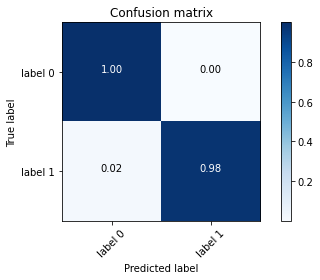

In [68]:
#Confusion matrix to analyse the faults 
y_pred=eclf.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

In [69]:
#TO SUBMIT
submit(model=eclf,X_exam=X_exam_scaled)

SCORE : ***0,99850***

With voting = 'soft'

In [70]:
eclf2 = VotingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('lgbm', clf3)],voting='soft')

In [71]:
eclf2.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03063585
Iteration 2, loss = 0.00673447
Iteration 3, loss = 0.00594956
Iteration 4, loss = 0.00560891
Iteration 5, loss = 0.00536448
Iteration 6, loss = 0.00522307
Iteration 7, loss = 0.00510961
Iteration 8, loss = 0.00505204
Iteration 9, loss = 0.00499033
Iteration 10, loss = 0.00494338
Iteration 11, loss = 0.00488052
Iteration 12, loss = 0.00484259
Iteration 13, loss = 0.00480436
Iteration 14, loss = 0.00478234
Iteration 15, loss = 0.00473177
Iteration 16, loss = 0.00469255
Iteration 17, loss = 0.00464473
Iteration 18, loss = 0.00461066
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


VotingClassifier(estimators=[('mlp',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(15,),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=500,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=0,
                                            shuffl...
                                             learning_rate=0.1, max_depth=-1,
                                    

In [72]:
s2=eclf2.score(X_test_scaled,y_test)

In [73]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.89308209990159 %.


Normalized confusion matrix
[[9.99643542e-01 3.56457928e-04]
 [1.94588021e-02 9.80541198e-01]]


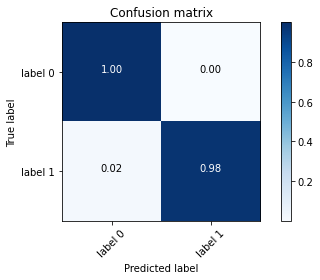

In [74]:
#Confusion matrix to analyse the faults 
y_pred=eclf2.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

In [75]:
#TO SUBMIT
submit(model=eclf2,X_exam=X_exam_scaled)

SCORE : ***0.99854***, a little better

Last try with weights : 2 for the better, 1 for the worst, 1.5 for the other.

In [77]:
eclf3 = VotingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('lgbm', clf3)],voting='soft',weights=[1, 1.5, 2])

In [78]:
eclf3.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03063585
Iteration 2, loss = 0.00673447
Iteration 3, loss = 0.00594956
Iteration 4, loss = 0.00560891
Iteration 5, loss = 0.00536448
Iteration 6, loss = 0.00522307
Iteration 7, loss = 0.00510961
Iteration 8, loss = 0.00505204
Iteration 9, loss = 0.00499033
Iteration 10, loss = 0.00494338
Iteration 11, loss = 0.00488052
Iteration 12, loss = 0.00484259
Iteration 13, loss = 0.00480436
Iteration 14, loss = 0.00478234
Iteration 15, loss = 0.00473177
Iteration 16, loss = 0.00469255
Iteration 17, loss = 0.00464473
Iteration 18, loss = 0.00461066
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


VotingClassifier(estimators=[('mlp',
                              MLPClassifier(activation='relu', alpha=0.0001,
                                            batch_size='auto', beta_1=0.9,
                                            beta_2=0.999, early_stopping=False,
                                            epsilon=1e-08,
                                            hidden_layer_sizes=(15,),
                                            learning_rate='constant',
                                            learning_rate_init=0.001,
                                            max_fun=15000, max_iter=500,
                                            momentum=0.9, n_iter_no_change=10,
                                            nesterovs_momentum=True,
                                            power_t=0.5, random_state=0,
                                            shuffl...
                                             learning_rate=0.1, max_depth=-1,
                                    

In [80]:
s2=eclf3.score(X_test_scaled,y_test)

In [87]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.8964853221859 %.


Normalized confusion matrix
[[9.99631758e-01 3.68241661e-04]
 [1.82426269e-02 9.81757373e-01]]


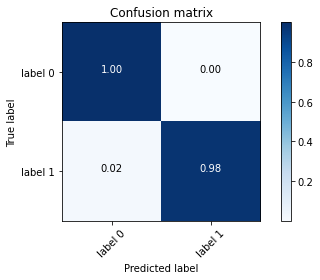

In [85]:
#Confusion matrix to analyse the faults 
y_pred=eclf3.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

In [86]:
#TO SUBMIT
submit(model=eclf3,X_exam=X_exam_scaled)

SCORE : ***0.99854*** again 

#### Stacking 

Model stacking is an efficient ensemble method in which the predictions, generated by using various machine learning algorithms, are used as inputs in a second-layer learning algorithm.

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [19]:
lf = StackingClassifier(estimators=[('mlp', clf1), ('xgb', clf2), ('lgbm', clf3)], final_estimator=LogisticRegression())

In [20]:
lf.fit(X_train_scaled,y_train)

Iteration 1, loss = 0.03095447
Iteration 2, loss = 0.00692235
Iteration 3, loss = 0.00606835
Iteration 4, loss = 0.00571230
Iteration 5, loss = 0.00545106
Iteration 6, loss = 0.00526997
Iteration 7, loss = 0.00512936
Iteration 8, loss = 0.00501429
Iteration 9, loss = 0.00494212
Iteration 10, loss = 0.00488490
Iteration 11, loss = 0.00486955
Iteration 12, loss = 0.00482306
Iteration 13, loss = 0.00477022
Iteration 14, loss = 0.00474189
Iteration 15, loss = 0.00468041
Iteration 16, loss = 0.00466272
Iteration 17, loss = 0.00461631
Iteration 18, loss = 0.00458956
Iteration 19, loss = 0.00456402
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.03646747
Iteration 2, loss = 0.00728592
Iteration 3, loss = 0.00629184
Iteration 4, loss = 0.00584611
Iteration 5, loss = 0.00560648
Iteration 6, loss = 0.00538092
Iteration 7, loss = 0.00517056
Iteration 8, loss = 0.00512061
Iteration 9, loss = 0.00500289
Iteration 10, loss = 0.00489919


StackingClassifier(cv=None,
                   estimators=[('mlp',
                                MLPClassifier(activation='relu', alpha=0.0001,
                                              batch_size='auto', beta_1=0.9,
                                              beta_2=0.999,
                                              early_stopping=False,
                                              epsilon=1e-08,
                                              hidden_layer_sizes=(15,),
                                              learning_rate='constant',
                                              learning_rate_init=0.001,
                                              max_fun=15000, max_iter=500,
                                              momentum=0.9, n_iter_no_change=10,
                                              nesterovs_momentum=True,
                                              power_t=0.5, random_stat...
                                               tree_learner='data',
   

In [21]:
s2=lf.score(X_test_scaled,y_test)

In [22]:
print("The score on the test set is :",s2*100,"%.")

The score on the test set is : 99.89620172032888 %.


Normalized confusion matrix
[[9.99661218e-01 3.38782328e-04]
 [2.09790210e-02 9.79020979e-01]]


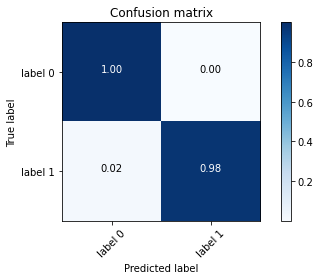

In [97]:
#Confusion matrix to analyse the faults 
y_pred=lf.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= classes_name ,normalize=True)
plt.show()

In [23]:
#TO SUBMIT
submit(model=lf,X_exam=X_exam_scaled)

SCORE : ***0.998564926095*** our best score ! 

## Conclusion 

Stats| .
- |-: 
Score  | 0.998598678358%
Ranking | 37/121 

What was interesting about this challenge was that it was the first time we had to deal with only the raw data. 
Our strategy was pretty standard, 
We started by training simple models at the beginning. 
However, we realized from the start that it was going to be played to the nearest thousandth. 


When we looked at the data at the beginning, we figured the big challenge would be to deal with unbalanced data. We figured that a lot of models were going to return the 0 label too often. 
That's why we took action on our data, using oversampling on class 0, undersampling on class 1, or even both at the same time. We also tried giving different weights to the two classes with the parameter class_weights that most methods have. 
All this was not very useful in the end. We have indeed noticed that overfitting was very rare here, there shouldn't be many outliers. 

So the interest was to find a model that was complex enough, given the number of data we had, and the high number of features that each one has. 

To do that, we split the task in two: 

- Marine worked in detail on the decision trees, with testing of several criteria such as GINI or cross-entropy, with Bagging testing, performance improvement with AdaBoost, and systematic search for the best possible parameters with cross-validation. 

- Paul focused on linear models, neural networks, before focusing on decision-tree-based algorithms that uses a gradient boosting framework such as xgboost. Finally, in order to improve the most possble score, he tried the VotingClassifier and Stacking ensemble methods which gave the final score.


What could have been improved : 

- We regret to have discovered more complex methods than those seen too late in class. We focused mainly on the methods in the course, when we could have moved faster towards more complex methods like xgboost, and the use of set methods. 

- We could have perform more clever data augmentation... In fact, each data represents score A/score B/score A-B where A and B are images and could have been transformed in score B/score A/score A-B but it's unfortunately too late to do this augmentation